In [ ]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
warnings.simplefilter("ignore")

In [18]:
from pathlib import Path
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.util import montage
from skimage.color import label2rgb

def create_rgb_montage(x):
    return np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def check_image_path_existence(df):
    return df['image_path'].map(lambda x: Path(x).exists())

    # Set the image directory and mapping file paths
image_dir = Path('..') / 'input' / 'skin-cancer-mnist-ham10000'
mapping_file = Path('..') / 'input' / 'skin-images-to-features' / 'color_features.json'
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
skin_df = pd.read_json(mapping_file)

image_path_existence = check_image_path_existence(skin_df)
print(image_path_existence.value_counts())
    
print(skin_df.sample(2))



image_path
True    9958
Name: count, dtype: int64
        lesion_id      image_id   dx    dx_type  age     sex     localization  \
7846  HAM_0003623  ISIC_0032788   nv      histo   50  female             back   
931   HAM_0004113  ISIC_0034165  bkl  consensus   55  female  lower extremity   

                                             image_path  \
7846  ../input/skin-cancer-mnist-ham10000/ham10000_i...   
931   ../input/skin-cancer-mnist-ham10000/ham10000_i...   

                    dx_name  dx_id  \
7846       melanocytic nevi      0   
931   benign keratosis-like      5   

                                         color_features  
7846  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
931   [0.009859259300000001, 0.0, 0.0, 0.0, 0.0, 0.0...  


In [8]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.35, stratify_column='dx_id'):
    train_df, validation_df = train_test_split(df, 
                                               test_size=test_size,
                                               stratify=df[stratify_column])
    return train_df, validation_df

def print_dataset_info(train_df, validation_df):
    print(f"{train_df.shape[0]} training masks")
    print(f"{validation_df.shape[0]} validation masks")

raw_train_df, valid_df = split_data(skin_df)

print_dataset_info(raw_train_df, valid_df)

6472 training masks
3486 validation masks


In [9]:
EPOCHS = 25
FLATTEN = True
GAUSSIAN_NOISE = 0.05
VALID_IMG_COUNT = 1500
SAMPLE_PER_GROUP = 2200
LEARN_RATE = 2e-4
DROPOUT = 0.5
DENSE_COUNT = 256
BASE_MODEL='MobileNet'
IMG_SIZE = (224, 224) 
BATCH_SIZE = 64
RGB_FLIP = 1

In [10]:
def create_balanced_training_set(raw_train_df, sample_per_group):
    balanced_train_df = (
        raw_train_df.groupby('dx_name')
        .apply(lambda x: x.sample(sample_per_group // 2, replace=True))
        .reset_index(drop=True)
    )
    return balanced_train_df

# Assuming raw_train_df and SAMPLE_PER_GROUP are defined earlier in the code
balanced_train_df = create_balanced_training_set(raw_train_df, SAMPLE_PER_GROUP)
print(balanced_train_df.shape[0])


7700


In [11]:
train_df = balanced_train_df
balanced_train_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,dx_name,dx_id,color_features
0,HAM_0003633,ISIC_0030280,akiec,histo,70,male,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Actinic keratoses and intraepithelial carcinoma,3,"[5.1851900000000004e-05, 0.0, 0.0, 0.0, 0.0, 0..."
1,HAM_0001694,ISIC_0032173,akiec,histo,80,female,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Actinic keratoses and intraepithelial carcinoma,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,HAM_0006481,ISIC_0026492,akiec,histo,70,male,upper extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,Actinic keratoses and intraepithelial carcinoma,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,HAM_0006213,ISIC_0025182,akiec,histo,60,female,hand,../input/skin-cancer-mnist-ham10000/ham10000_i...,Actinic keratoses and intraepithelial carcinoma,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,HAM_0001505,ISIC_0024511,akiec,histo,55,female,face,../input/skin-cancer-mnist-ham10000/ham10000_i...,Actinic keratoses and intraepithelial carcinoma,3,"[0.0002888889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
...,...,...,...,...,...,...,...,...,...,...,...
7695,HAM_0001780,ISIC_0024370,vasc,consensus,55,male,trunk,../input/skin-cancer-mnist-ham10000/ham10000_i...,vascular lesions,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7696,HAM_0005989,ISIC_0031648,vasc,histo,25,female,back,../input/skin-cancer-mnist-ham10000/ham10000_i...,vascular lesions,4,"[0.0011259259, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
7697,HAM_0001852,ISIC_0033749,vasc,histo,80,male,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,vascular lesions,4,"[0.0014481481, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
7698,HAM_0000494,ISIC_0032557,vasc,histo,55,male,lower extremity,../input/skin-cancer-mnist-ham10000/ham10000_i...,vascular lesions,4,"[6.2963e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [13]:
from keras.applications.mobilenet_v2 import MobileNetV2 as PTModel, preprocess_input

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters
augmentation_params = {
    'featurewise_center': False,
    'samplewise_center': False,
    'rotation_range': 45,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.01,
    'zoom_range': [0.9, 1.25],
    'brightness_range': [0.7, 1.3],
    'horizontal_flip': True,
    'vertical_flip': False,
    'fill_mode': 'reflect',
    'data_format': 'channels_last',
    'preprocessing_function': preprocess_input
}

# Define validation parameters
validation_params = {
    'fill_mode': 'reflect',
    'data_format': 'channels_last',
    'preprocessing_function': preprocess_input
}

# Create ImageDataGenerator instances
core_idg = ImageDataGenerator(**augmentation_params)
valid_idg = ImageDataGenerator(**validation_params)


In [15]:

def flow_from_dataframe(img_data_gen, raw_df, path_col, y_col, **dflow_args):
    processed_df = raw_df.copy()
    processed_df[path_col] = processed_df[path_col].astype(str)
    processed_df[y_col] = processed_df[y_col].apply(lambda x: np.array(x))

    df_gen = img_data_gen.flow_from_dataframe(
        dataframe=processed_df,
        x_col=path_col,
        y_col=y_col,
        class_mode='raw',
        **dflow_args
    )

    # Posthoc correction
    df_gen._targets = np.stack(df_gen.labels, 0)
    return df_gen


In [16]:
def create_data_generator(img_data_gen, dataframe, path_col, y_col, target_size, color_mode, batch_size):
    df_gen = flow_from_dataframe(img_data_gen, dataframe, path_col, y_col, target_size=target_size, color_mode=color_mode, batch_size=batch_size)
    return df_gen

def generate_validation_data(valid_idg, valid_df, path_col, y_col, target_size, color_mode, valid_img_count):
    valid_gen = flow_from_dataframe(valid_idg, valid_df, path_col=path_col, y_col=y_col, target_size=target_size, color_mode=color_mode, batch_size=valid_img_count)
    valid_x, valid_y = next(valid_gen)
    return valid_x, valid_y

train_gen = create_data_generator(core_idg, train_df, path_col='image_path', y_col='dx_id', target_size=IMG_SIZE, color_mode='rgb', batch_size=BATCH_SIZE)

valid_x, valid_y = generate_validation_data(valid_idg, valid_df, path_col='image_path', y_col='dx_id', target_size=IMG_SIZE, color_mode='rgb', valid_img_count=VALID_IMG_COUNT)

print(valid_x.shape, valid_y.shape)

Found 7700 validated image filenames.
Found 3486 validated image filenames.
(1500, 224, 224, 3) (1500,)


x (64, 224, 224, 3) float32 -1.0 1.0
y (64,) int64 0 6


Text(0.5, 1.0, 'images')

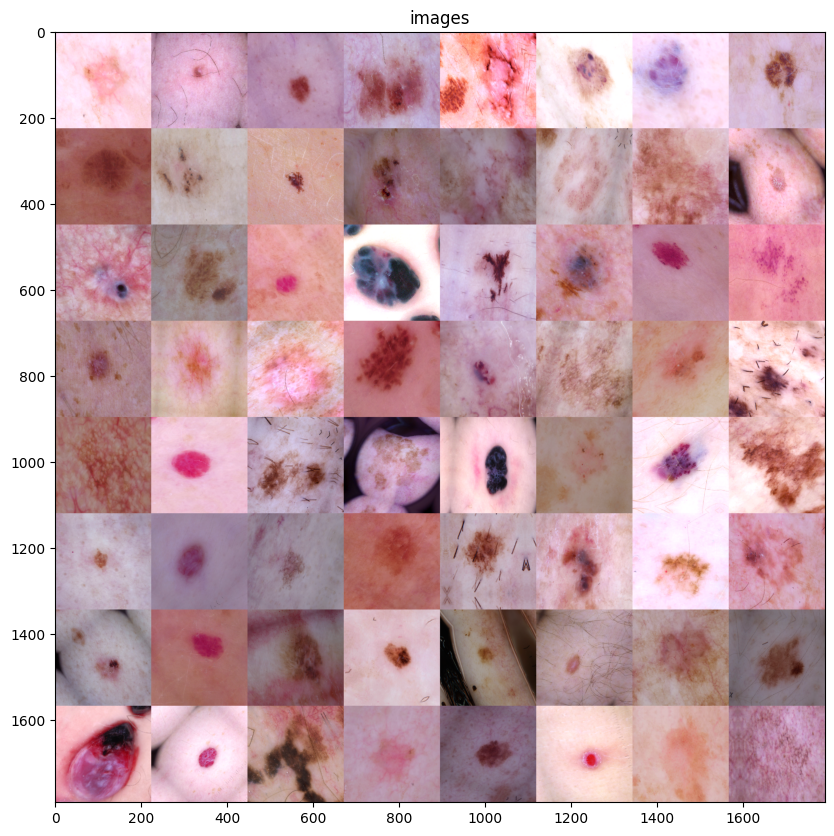

In [22]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_gen)

print('x', x_batch.shape, x_batch.dtype, x_batch.min(), x_batch.max())
print('y', y_batch.shape, y_batch.dtype, y_batch.min(), y_batch.max())

normalized_images = (x_batch - x_batch.min()) / (x_batch.max() - x_batch.min())
montage_rgb_images = montage_rgb(normalized_images)[:, :, ::RGB_FLIP]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(montage_rgb_images)
ax1.set_title('images')


In [23]:
x_batch.shape[1:]

(224, 224, 3)

In [24]:
base_pretrained_model = PTModel(input_shape =  x_batch.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
from keras import models, layers
from keras.optimizers import Adam

def build_skin_model(input_shape, base_pretrained_model, gaussian_noise, dropout, dense_count, flatten=True):
    img_in = layers.Input(input_shape, name='Image_RGB_In')
    img_noise = layers.GaussianNoise(gaussian_noise)(img_in)
    pt_features = base_pretrained_model(img_noise)
    pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
    bn_features = layers.BatchNormalization()(pt_features)
    feature_dropout = layers.SpatialDropout2D(dropout)(bn_features)

    if flatten:
        flat_layer = layers.Flatten()(bn_features)
        collapsed_layer = layers.Dropout(dropout)(flat_layer)
    else:
        collapsed_layer = layers.GlobalAveragePooling2D()(bn_features)

    dr_steps = layers.Dropout(dropout)(layers.Dense(dense_count, activation='relu')(collapsed_layer))
    out_layer = layers.Dense(train_df['dx_id'].max() + 1, activation='softmax')(dr_steps)

    skin_model = models.Model(inputs=[img_in], outputs=[out_layer], name='full_model')

    skin_model.compile(
        optimizer=Adam(lr=LEARN_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    return skin_model

input_shape = x_batch.shape[1:]
skin_model = build_skin_model(input_shape, base_pretrained_model, GAUSSIAN_NOISE, DROPOUT, DENSE_COUNT, flatten=FLATTEN)
skin_model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_RGB_In (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 gaussian_noise (GaussianNo  (None, 224, 224, 3)       0         
 ise)                                                            
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 1280)        5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                        

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define file path for saving the best weights
weight_path = "skin_cancer_detector_weights.best.hdf5"

# ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

# ReduceLROnPlateau callback for dynamic learning rate adjustment
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.8, 
                                         patience=10, 
                                         verbose=1, 
                                         mode='auto', 
                                         epsilon=0.0001, 
                                         cooldown=5, 
                                         min_lr=0.0001)

# EarlyStopping callback to stop training if validation loss doesn't improve
early_stopping = EarlyStopping(monitor="val_loss", 
                               mode="min", 
                               patience=15)

# List of callbacks to be used during training
callbacks_list = [checkpoint, early_stopping, reduce_lr_on_plateau]

In [ ]:
from IPython.display import clear_output

train_gen.batch_size = BATCH_SIZE

fit_results = skin_model.fit(x=train_gen,
                             steps_per_epoch=train_gen.samples // BATCH_SIZE,
                             validation_data=(valid_x, valid_y),
                             epochs=EPOCHS,
                             callbacks=callbacks_list,
                             workers=3)

Epoch 1/25
120/120 [==============================] - ETA: 0s - loss: 2.3649 - sparse_categorical_accuracy: 0.4113
Epoch 1: val_loss improved from inf to 1.85042, saving model to skin_cancer_detector_weights.best.hdf5
120/120 [==============================] - 342s 3s/step - loss: 2.3649 - sparse_categorical_accuracy: 0.4113 - val_loss: 1.8504 - val_sparse_categorical_accuracy: 0.5160 - lr: 0.0010
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 1.4845 - sparse_categorical_accuracy: 0.4855
Epoch 2: val_loss improved from 1.85042 to 1.51414, saving model to skin_cancer_detector_weights.best.hdf5
120/120 [==============================] - 329s 3s/step - loss: 1.4845 - sparse_categorical_accuracy: 0.4855 - val_loss: 1.5141 - val_sparse_categorical_accuracy: 0.4980 - lr: 0.0010
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 1.3724 - sparse_categorical_accuracy: 0.5085
Epoch 3: val_loss improved from 1.51414 to 1.47078, saving model to skin_cancer

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Loss
axes[0].plot(fit_results.history['loss'], label='Training')
axes[0].plot(fit_results.history['val_loss'], label='Validation')
axes[0].legend()
axes[0].set_title('Loss')

# Plot Binary Accuracy
axes[1].plot(fit_results.history['sparse_categorical_accuracy'], label='Training')
axes[1].plot(fit_results.history['val_sparse_categorical_accuracy'], label='Validation')
axes[1].legend()
axes[1].set_title('Binary Accuracy')
axes[1].set_ylim(0, 1)

plt.show()


In [ ]:
skin_model.load_weights(weight_path)
skin_model.save('skin_cancer_model.h5')

In [ ]:
evaluation_results = skin_model.evaluate(valid_x, valid_y)
for metric_name, metric_value in zip(skin_model.metrics_names, evaluation_results):
    if metric_name != 'loss':
        print(f'{metric_name:40s}:\t{100 * metric_value:.1f}%')

In [ ]:
dx_lookup_dict = train_df[['dx_id', 'dx_name']].drop_duplicates().set_index('dx_id')['dx_name'].to_dict()

In [ ]:
# Assuming t_x, t_y, and dx_lookup_dict are defined earlier
t_yp = skin_model.predict(t_x)

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    normalized_image = (t_x[i] - t_x.min()) / (t_x.max() - t_x.min())
    ax.imshow(normalized_image[:, ::RGB_FLIP])

    true_class_name = dx_lookup_dict[t_y[i]]
    predicted_percentage = 100 * t_yp[i, t_y[i]]
    title_text = f'{true_class_name}\nPred: {predicted_percentage:.1f}%'
    
    ax.set_title(title_text)
    ax.axis('off')

plt.show()
